In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from fnmatch import fnmatch
import scipy.stats as stats
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)
from notebooks.notebook_helpers import *

from scripts.log_action import log_action_v2
from time import sleep

# Set defaults

In [38]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_names = ["ET2_EPIR_Batch_1_1_HV220"]
chip_names = ["ET2_W12_5_3_HV240"]
chip_names = ["ET2_Pair3_HV290", "ET2_EPIR_Pair4_HV240", "ET2_EPIR_Pair5_HV220"]
chip_names = ["ET2_Pair3_HV290", "ET2_W12_5_3_HV240"]
chip_names = ["ET2_Pair3_HV285", "ET2_W12_5_3_HV240", "ET2_W12_2_3_HV120"]
chip_names = ["ET2_Pair3_HV290", "ET2_W12_5_3_HV240", "ET2_W12_5_5_HV240"]
chip_names = ["ET2_Pair3_HV290", "ET2_W12_5_3_HV240", "ET2_EPIR_Batch_1_1_HV280"]
# chip_names = ["ET2_W12_5_3", "ET2_W12_5_5"]
#chip_names = ["ET2_Pair3", "ET2_W12_5_3"]
chip_fignames = chip_names
chip_figtitles = ["ETROC2 EPIR Batch 1-1 HV 220"]  # EPIR Batch 1-1
chip_figtitles = ["ETROC2 W12 5-3 HV 240"]
chip_figtitles = ["ETROC2 EPIR Pair 3 HV290", "ETROC2 W12 5-3 HV 240"]
chip_figtitles = ["ETROC2 EPIR Pair 3 HV 285", "ETROC2 W12 5-3 HV 240", "ETROC2 W12 2-3 HV 120"]
chip_figtitles = ["ETROC2 EPIR Pair 3 HV 290", "ETROC2 W12 5-3 HV 240", "ETROC2 EPIR_Batch 1-1 HV280"]
# chip_figtitles = ["ETROC2 W12 5-3", "ETROC2 W12 5-5"]
#chip_figtitles = ["ETROC2 EPIR Pair 3", "ETROC2 W12 5-3"]

# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM1"
# I2C addresses for the pixel block and WS
chip_addresses = [0x60, 0x61, 0x62]
# chip_addresses = [0x61, 0x62]
ws_addresses = [None, None, None]

# i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
# i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
# #i2c_gui.__no_connect_type__ = "check"  # default behaviour

hostname = "192.168.2.3"

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# polarity = "0x0022"
polarity = "0x0027"

# Make i2c_connection class object

In [4]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,ws_addresses,chip_names,[("1","1"), ("1","1"), ("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [37]:
# 0 - 0 - (disable & auto_cal all pixels) - (disable default all pixels) - (auto_TH_CAL) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100111')

Passed pixel check for chip: 0x60
Passed peripheral write check for chip: 0x60
Peripherals set for chip: 0x60
Disabled pixels for chip: 0x60


Calibrating row: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]


Auto calibration finished for chip: 0x60
Passed pixel check for chip: 0x61
Passed peripheral write check for chip: 0x61
Peripherals set for chip: 0x61
Disabled pixels for chip: 0x61


Calibrating row: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]


Auto calibration finished for chip: 0x61
Passed pixel check for chip: 0x62
Passed peripheral write check for chip: 0x62
Peripherals set for chip: 0x62
Disabled pixels for chip: 0x62


Calibrating row: 100%|██████████| 16/16 [01:29<00:00,  5.60s/it]

Auto calibration finished for chip: 0x62


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [39]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

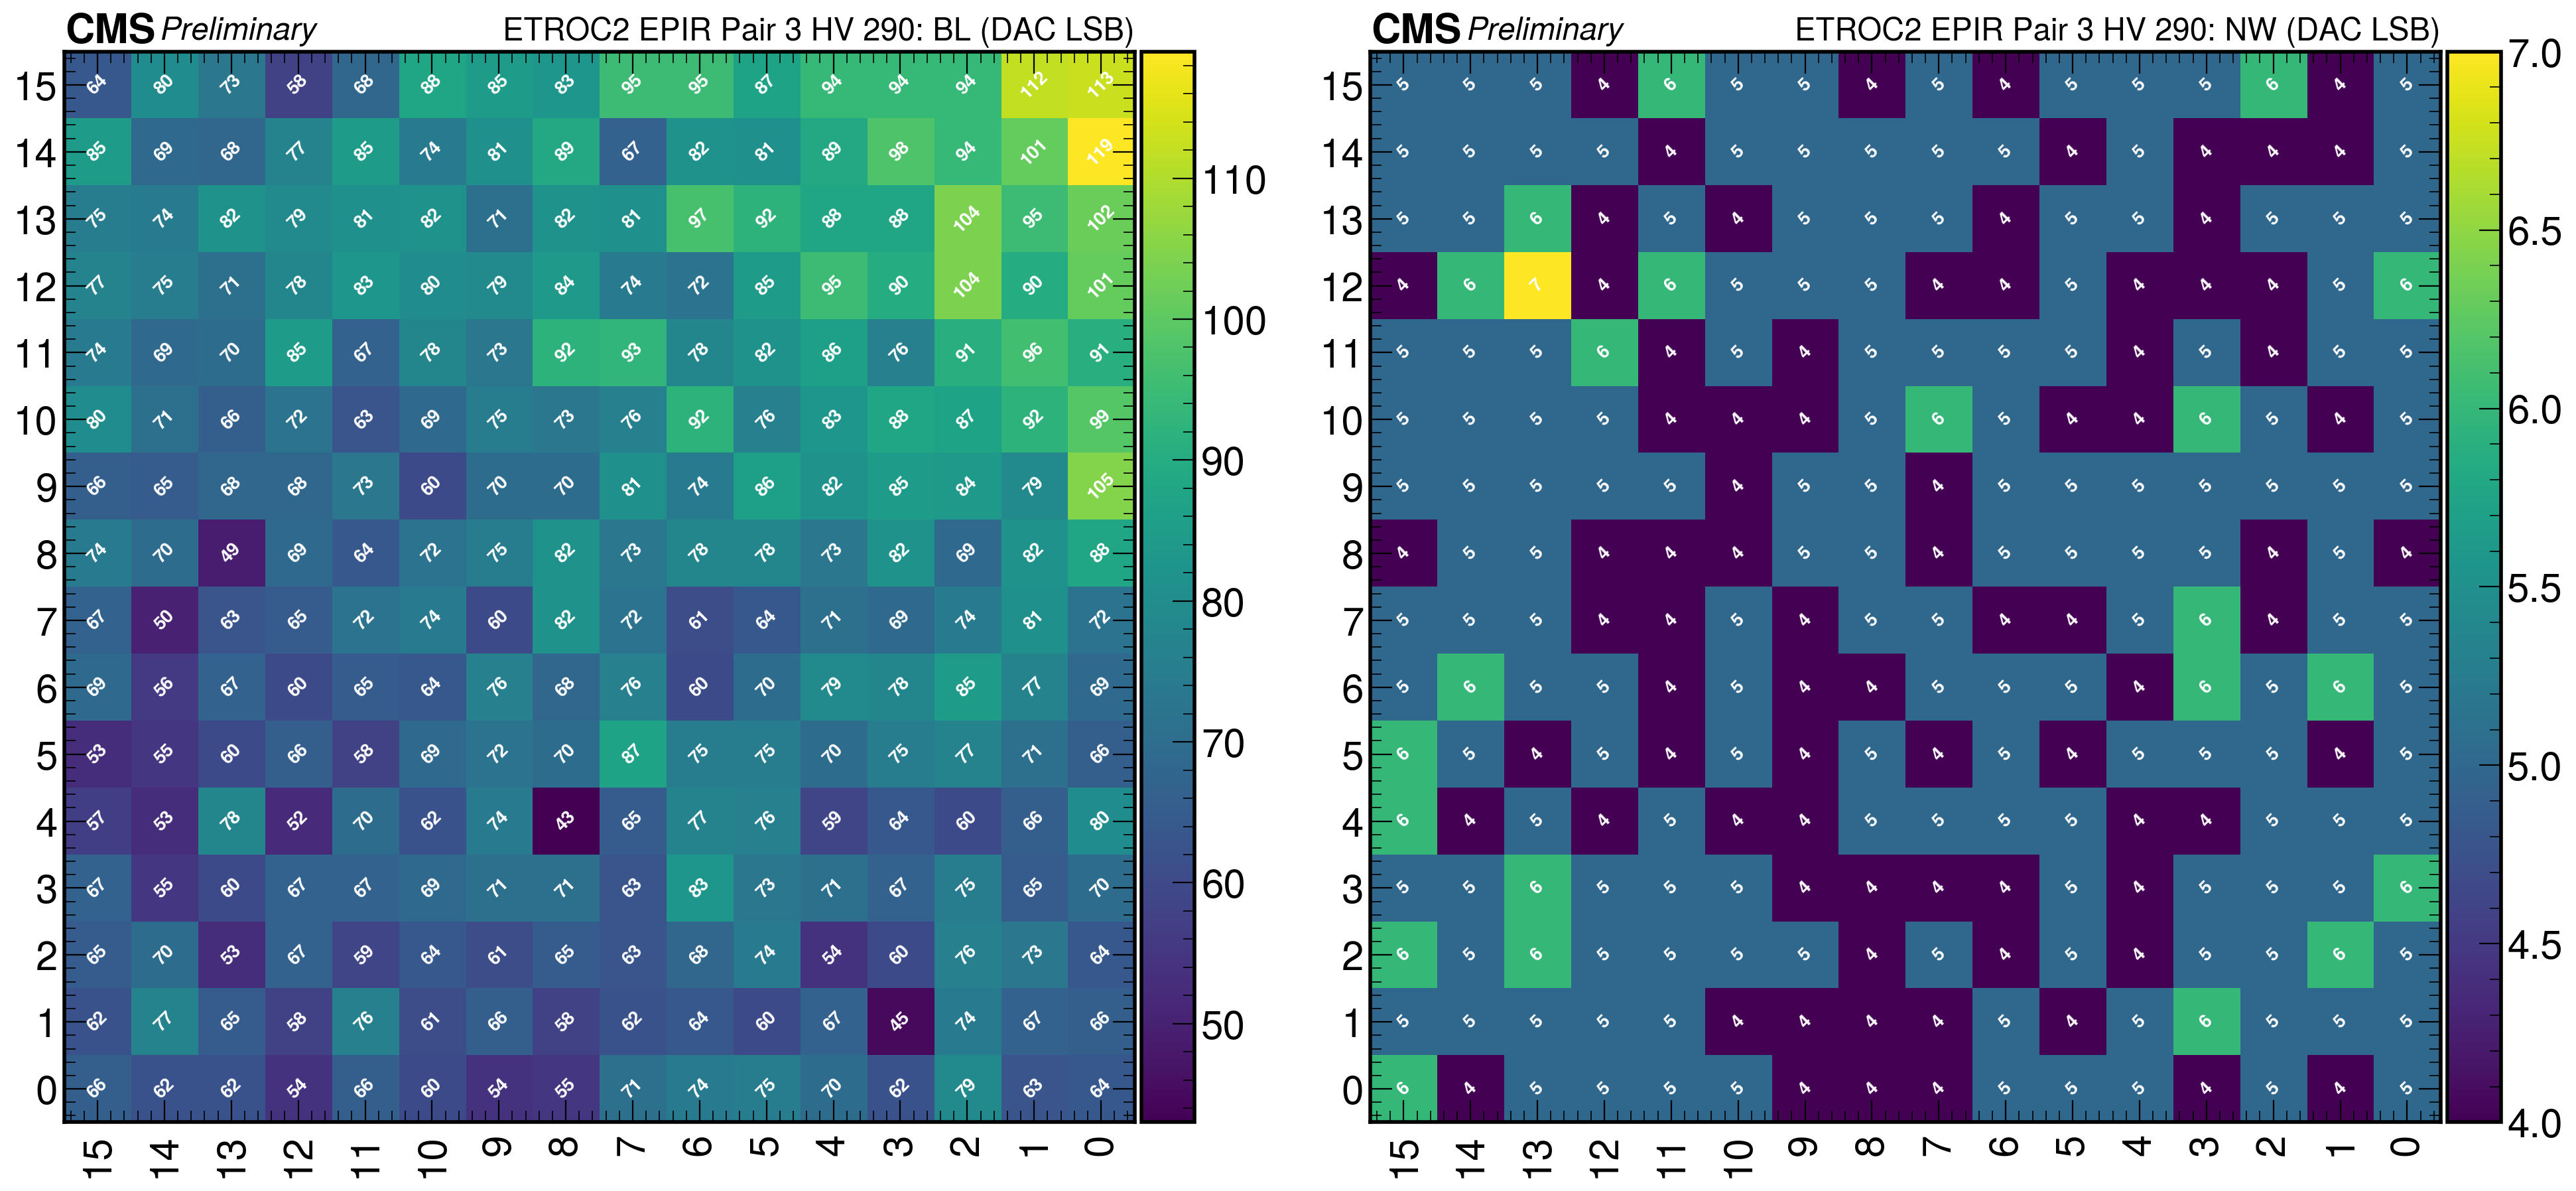

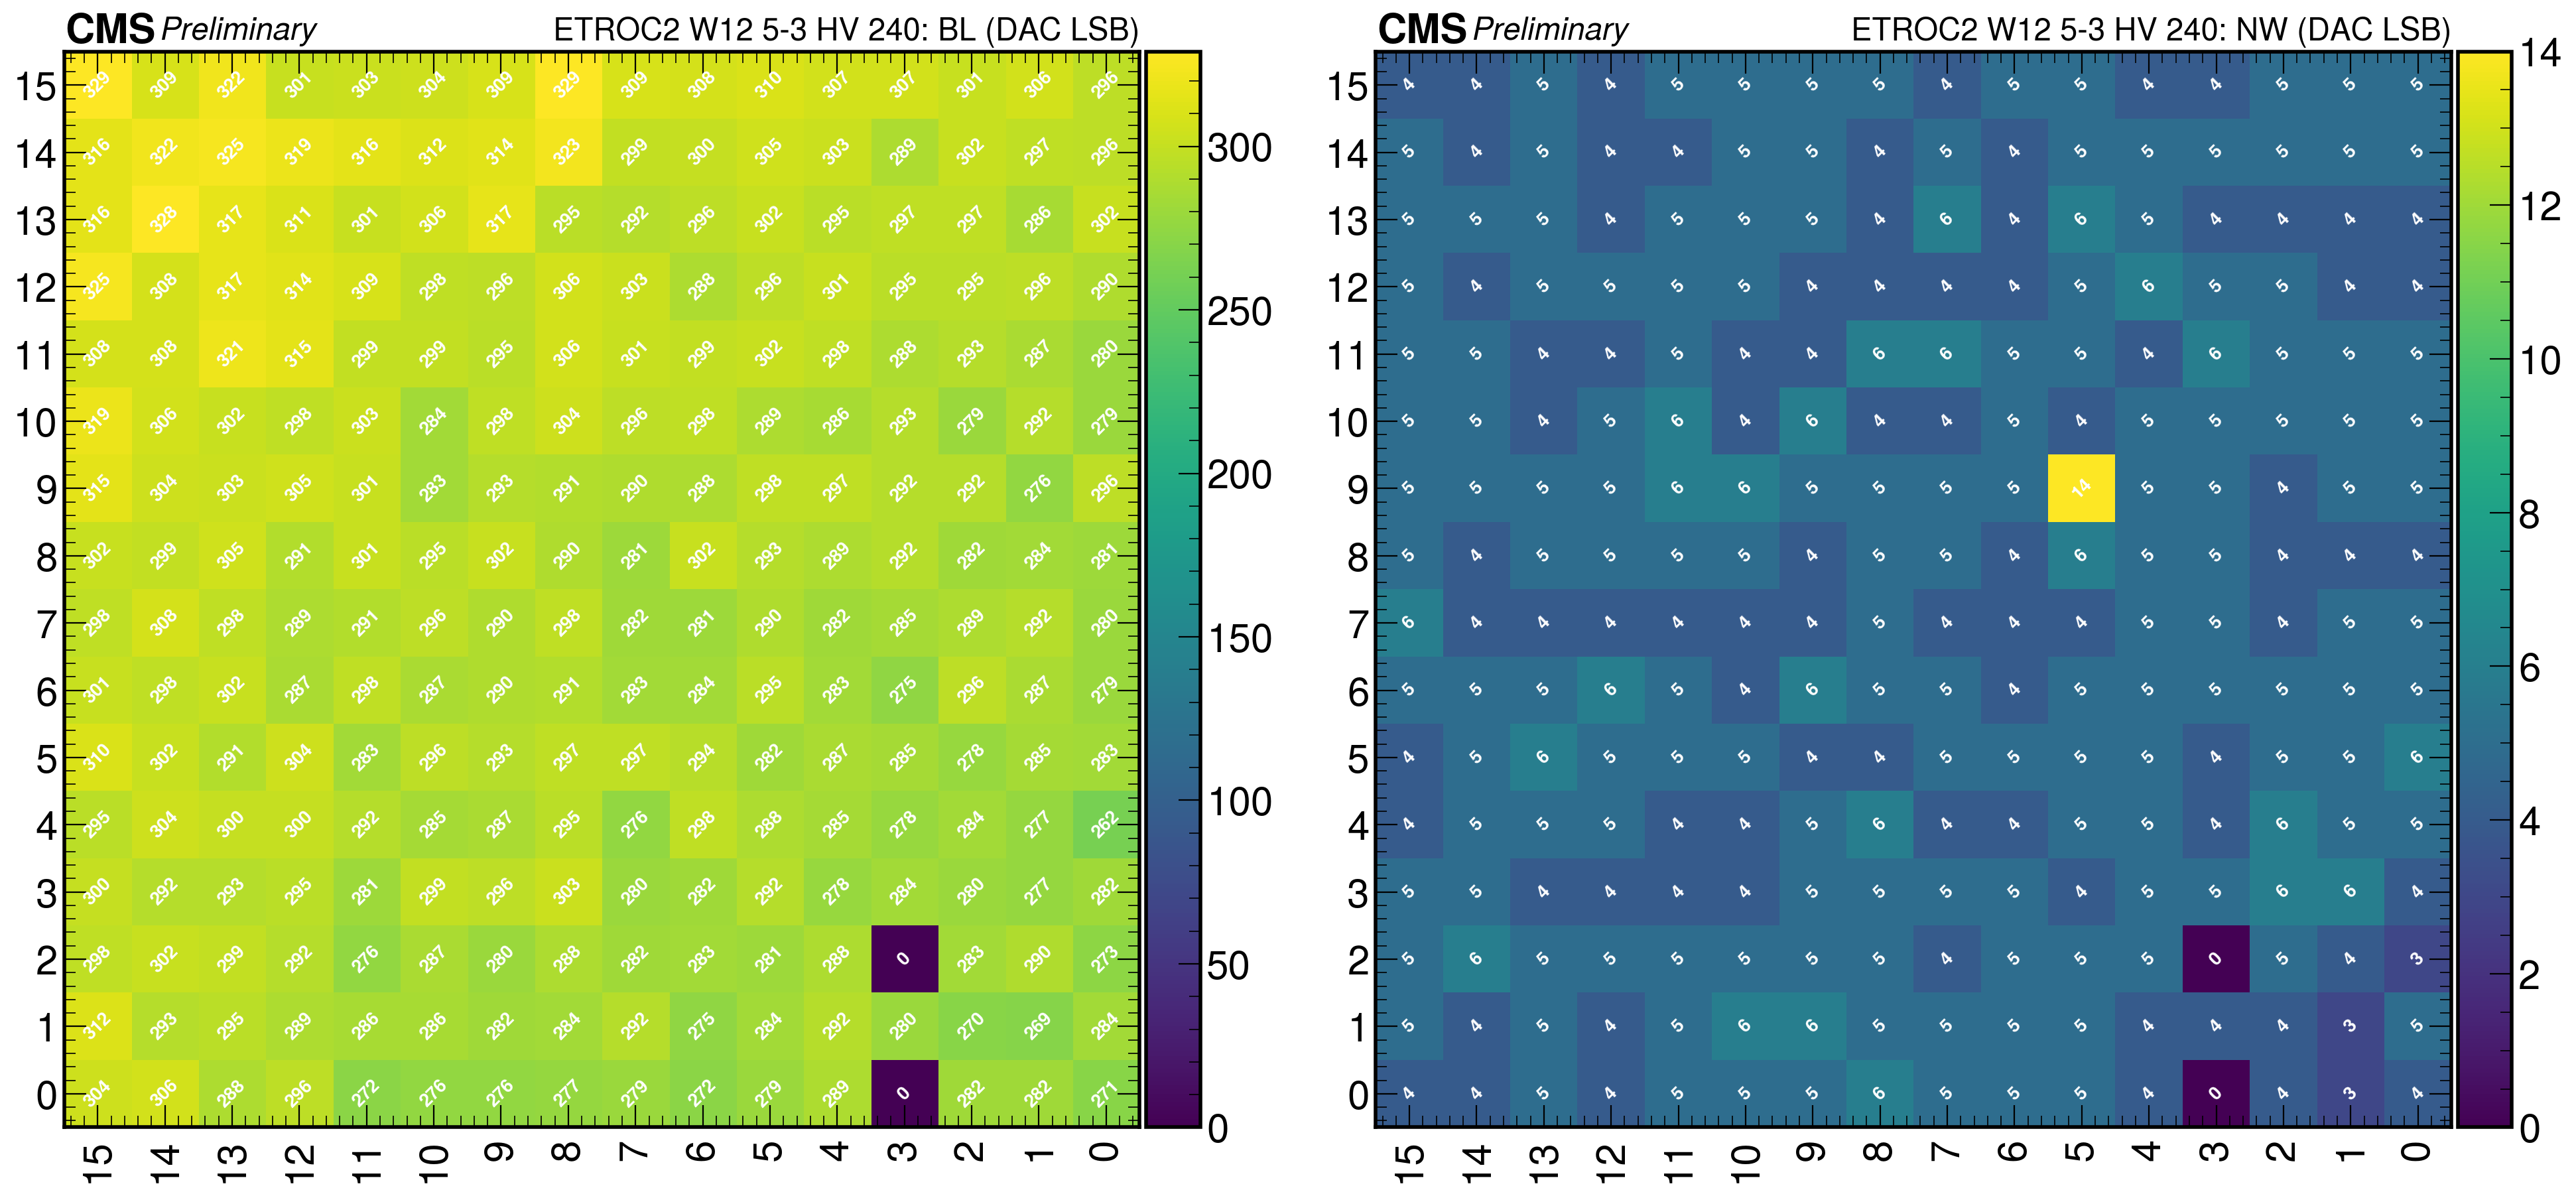

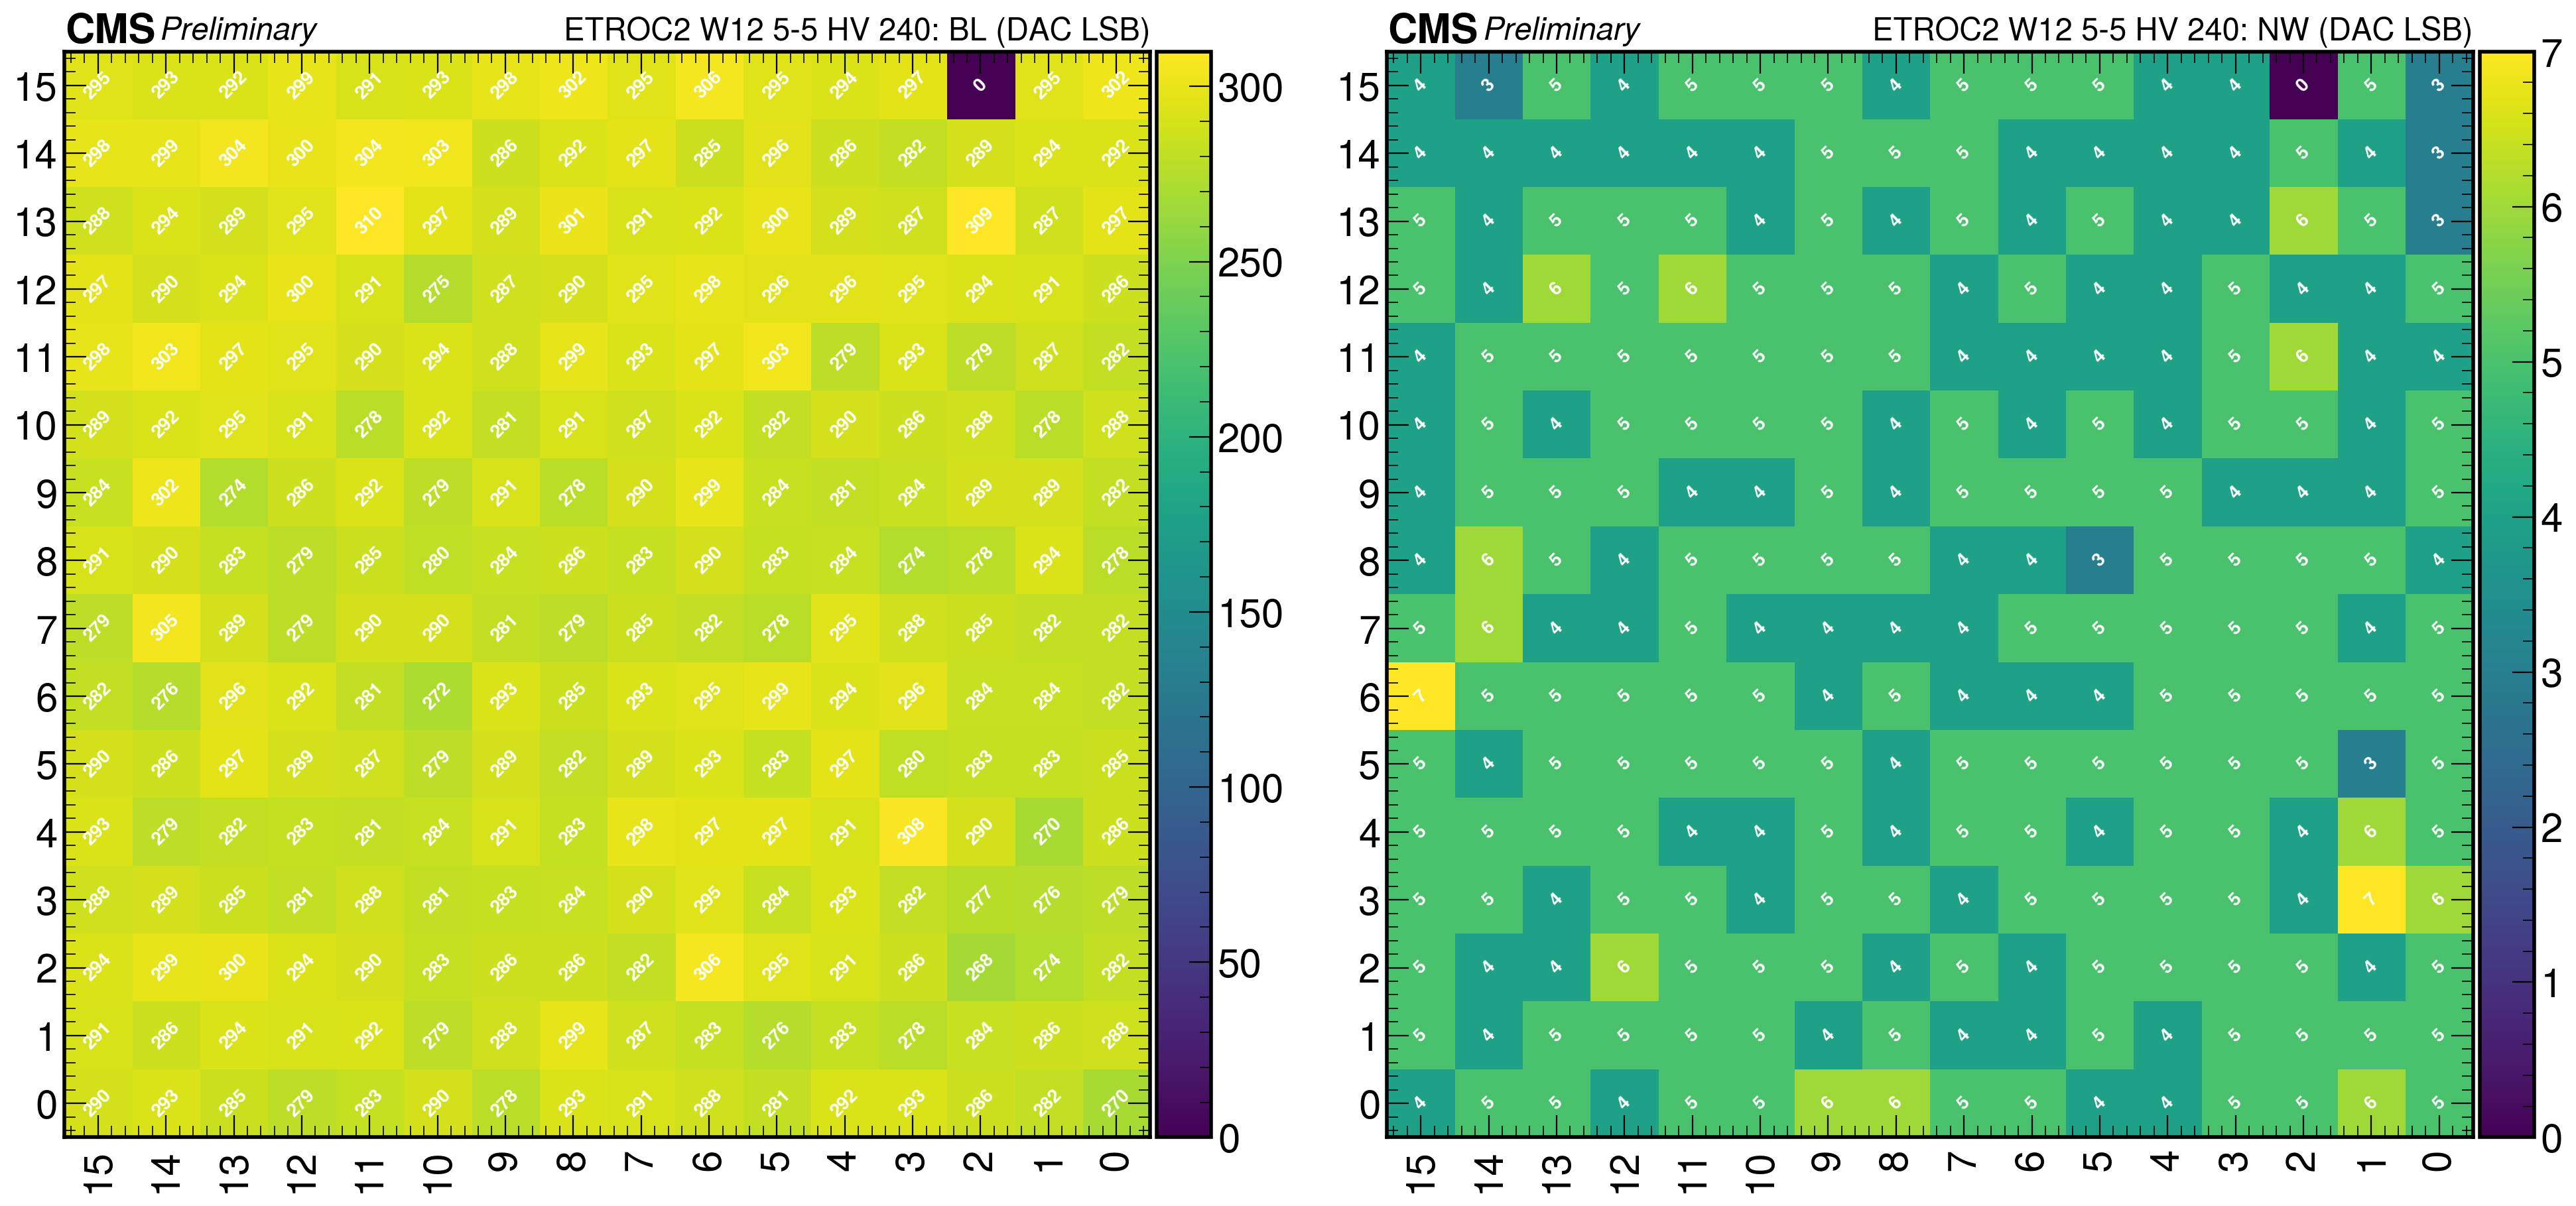

In [40]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

# Define pixels of interest

In [21]:
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [15, 15, 15, 15]
# col_list = [6, 7, 8, 9]
# row_list = [14, 14, 15, 15]
# col_list = [6, 9, 6, 9]
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]
row_list = [14]
col_list = [6]

scan_list = list(zip(row_list, col_list))
print(scan_list)

col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
scan_list = list(zip(row_list.flatten(),col_list.flatten()))

[(14, 6)]


### Enable pixels of Interest

In [22]:
i2c_conn.enable_select_pixels_in_chips(scan_list, QInjEn=False)

Enabled pixel (0,0) for chip: 0x60
Enabled pixel (0,1) for chip: 0x60
Enabled pixel (0,2) for chip: 0x60
Enabled pixel (0,3) for chip: 0x60
Enabled pixel (0,4) for chip: 0x60
Enabled pixel (0,5) for chip: 0x60
Enabled pixel (0,6) for chip: 0x60
Enabled pixel (0,7) for chip: 0x60
Enabled pixel (0,8) for chip: 0x60
Enabled pixel (0,9) for chip: 0x60
Enabled pixel (0,10) for chip: 0x60
Enabled pixel (0,11) for chip: 0x60
Enabled pixel (0,12) for chip: 0x60
Enabled pixel (0,13) for chip: 0x60
Enabled pixel (0,14) for chip: 0x60
Enabled pixel (0,15) for chip: 0x60
Enabled pixel (1,0) for chip: 0x60
Enabled pixel (1,1) for chip: 0x60
Enabled pixel (1,2) for chip: 0x60
Enabled pixel (1,3) for chip: 0x60
Enabled pixel (1,4) for chip: 0x60
Enabled pixel (1,5) for chip: 0x60
Enabled pixel (1,6) for chip: 0x60
Enabled pixel (1,7) for chip: 0x60
Enabled pixel (1,8) for chip: 0x60
Enabled pixel (1,9) for chip: 0x60
Enabled pixel (1,10) for chip: 0x60
Enabled pixel (1,11) for chip: 0x60
Enabled pixe

In [10]:
offset = 0x0a
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '0', chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

Operating on chip 0x60 Pixel (14,6)
Operating on chip 0x61 Pixel (14,6)
Operating on chip 0x62 Pixel (14,6)


### Adjust Offset

In [23]:
offsets = {
    0x60: 0x0a,
    0x61: 0x0a,
    0x62: 0x0a
}

for chip_address in chip_addresses:
    if chip_address not in offsets:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offsets[chip_address], '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle


Operating on chip 0x60 Pixel (0,0)
Operating on chip 0x60 Pixel (0,1)
Operating on chip 0x60 Pixel (0,2)
Operating on chip 0x60 Pixel (0,3)
Operating on chip 0x60 Pixel (0,4)
Operating on chip 0x60 Pixel (0,5)
Operating on chip 0x60 Pixel (0,6)
Operating on chip 0x60 Pixel (0,7)
Operating on chip 0x60 Pixel (0,8)
Operating on chip 0x60 Pixel (0,9)
Operating on chip 0x60 Pixel (0,10)
Operating on chip 0x60 Pixel (0,11)
Operating on chip 0x60 Pixel (0,12)
Operating on chip 0x60 Pixel (0,13)
Operating on chip 0x60 Pixel (0,14)
Operating on chip 0x60 Pixel (0,15)
Operating on chip 0x60 Pixel (1,0)
Operating on chip 0x60 Pixel (1,1)
Operating on chip 0x60 Pixel (1,2)
Operating on chip 0x60 Pixel (1,3)
Operating on chip 0x60 Pixel (1,4)
Operating on chip 0x60 Pixel (1,5)
Operating on chip 0x60 Pixel (1,6)
Operating on chip 0x60 Pixel (1,7)
Operating on chip 0x60 Pixel (1,8)
Operating on chip 0x60 Pixel (1,9)
Operating on chip 0x60 Pixel (1,10)
Operating on chip 0x60 Pixel (1,11)
Operating on

### Remove noisy pixels from Trigger

In [24]:
noisy_pixels = {
    0x61: [ # (row, col)
        (0, 3),
        (2, 3),
        (9, 5)
    ],
    0x62: [ # (row, col)
        (15, 2),
    ],
}

for chip_address in chip_addresses:
    if chip_address not in noisy_pixels:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in noisy_pixels[chip_address]:
        print(f"Masking from trigger of chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("disTrigPath", "1", chip)
        i2c_conn.pixel_decoded_register_write("DAC", format(1023, '010b'), chip)
        i2c_conn.pixel_decoded_register_write("Bypass_THCal", "1", chip)



Masking from trigger of chip 0x61 Pixel (0,3)
Masking from trigger of chip 0x61 Pixel (2,3)
Masking from trigger of chip 0x61 Pixel (9,5)
Masking from trigger of chip 0x62 Pixel (15,2)


### QInj Pixels

In [20]:
qinj_pixels = {
    0x60: [ # (row, col)
        (14, 6),
    ],
    0x61: [ # (row, col)
        (14, 6),
    ],
    0x62: [ # (row, col)
        (14, 6),
    ],
}

for chip_address in chip_addresses:
    if chip_address not in qinj_pixels:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in qinj_pixels[chip_address]:
        print(f"Enabling QInj of chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("QInjEn", '0', chip)


Enabling QInj of chip 0x60 Pixel (14,6)
Enabling QInj of chip 0x61 Pixel (14,6)
Enabling QInj of chip 0x62 Pixel (14,6)


### Disable Pixels of Interest

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row,col in scan_list:
        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

# Calibrate PLL

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

# Calibrate FC

In [11]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

Reset Global Readout done for chip: 0x60
asyAlignFastcommand action done for chip: 0x60
Reset Global Readout done for chip: 0x61
asyAlignFastcommand action done for chip: 0x61
Reset Global Readout done for chip: 0x62
asyAlignFastcommand action done for chip: 0x62


# Run One Time DAQ to Set FPGA Firmware

In [13]:
#parser = run_script.getOptionParser()
parser = parser_arguments.create_parser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board0_NoLinkCheck -w -s 0x0000 -p 0x000f -d 0x1800 -a 0x0077 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
# f'main_process_Start_LEDs_Board0_NoLinkCheck'
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, None))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

start main process
Setting firmware...
Clearing FIFO for ALL boards...
Acting upon channel 0 ...
Acting upon channel 1 ...
Acting upon channel 2 ...
Directory ../ETROC-Data/2023-11-29_Array_Test_Results already exists!
User defined directory ../ETROC-Data/2023-11-29_Array_Test_Results/CanBeRemoved_Board0_NoLinkCheck already created!
Receive_data is reading data and pushing to the queue...
Write_data is reading queue and writing file 0...Message: memoFC Start Triggerbit QInj L1A BCR

Translate_data is reading queue and translating file 0...
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hitmap
Dumped at hi

# Run DAQ with Self-Trigger

### Find the right delay (use the middle of the three success modes, where both Qinj eges are caught)

In [ ]:
for inum in range(480, 490, 1):
    trigger_bit_delay = inum
    print(inum)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 15 -o CanBeRemoved_Board0_LinkCheck_selfTrigger_delay{inum} -v -w -s 0x0000 -p {polarity} -d {int('000111'+format(inum, '010b'), base=2)} -a 0x0011".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger_delay{inum}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(10)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

### Self-triggering with Board 0

In [ ]:
trigger_bit_delay = int('000111'+format(484, '010b'), base=2)
parser = parser_arguments.create_parser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 70 -o CanBeRemoved_Board0_LinkCheck_selfTrigger -v -w -s 0x0000 -p {polarity} -d {trigger_bit_delay} -a 0x0001 --counter_duration 0x0001 --compressed_translation --check_valid_data_start".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger'))
process.start()

#IPC_queue.put('memoFC Start Triggerbit QInj BCR')
IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(60)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-triggering with Board 1

In [ ]:
trigger_bit_delay = int('001011'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 70 -o CanBeRemoved_Board1_LinkCheck_selfTrigger -v -w -s 0x0004 -p {polarity} -d {trigger_bit_delay} -a 0x0002 --counter_duration 0x0001 --compressed_translation --check_valid_data_start".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board1_LinkCheck_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(60)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-triggering with Board 3

In [35]:
# check_valid_data_start clear_fifo
trigger_bit_delay = int('010011'+format(485, '010b'), base=2)
# parser = run_script.getOptionParser()
parser = parser_arguments.create_parser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 305 -o CanBeRemoved_Board3_LinkCheck_selfTrigger_2 -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0077 --counter_duration 0x0001 --compressed_translation".split())
IPC_queue = multiprocessing.Queue()
# process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board3_LinkCheck_selfTrigger'))
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, None))
process.start()

# IPC_queue.put('memoFC Start Triggerbit QInj BCR')
IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(300)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

start main process
Verbose Output:  True


-------------------------------------------
--------Set of inputs from the USER--------
Overwrite previously saved files:  True
FPGA IP Address:  192.168.2.3
Number of lines per file created by DAQ script:  50000
Number of lines read per call of fifo readout:  50000
Number of seconds to run this code (>0 means effective):  305
User defined Output Directory:  CanBeRemoved_Board3_LinkCheck_selfTrigger_2
Save only the untranslated FPGA binary data (raw output):  False
Save FPGA binary data (raw output) in int format:  False
Save only FPGA translated data frames with DATA:  True
DO NOT save binary data (raw output):  False
--------End of inputs from the USER--------
-------------------------------------------


-------------------------------------------
-------Inputs that have been pre-set-------
ETROC Board Type:  [2, 2, 2, 2]
ETROC Board Size:  [256, 256, 256, 256]
ETROC Board Name:  ['F28', 'F29', 'F30', 'F47']
ETROC Chip ID:  ['10111111100001

# Take data

In [36]:
trigger_bit_delay = int('000111'+format(485, '010b'), base=2)
total_time = 1 * 60 * 60  # Time in seconds for overall run
daq_time = 300  # Time in seconds for data taking process
process_time = daq_time + 10
from math import ceil
iterations = ceil(total_time/process_time)

for it in range(iterations):
    first_loop = ""
    # if it == 0:
    #     first_loop = "--check_valid_data_start"
    parser = parser_arguments.create_parser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t {process_time} -o SelfTrigger_{chip_names[0]}_Readout_offset{offset}_lowpower_cosmics_loop_{it} -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0077 --counter_duration 0x0001 --compressed_translation --ssd --skip_binary {first_loop}".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_SelfTrigger_{chip_names[0]}_Readout_offset{offset}_lowpower_cosmics_loop_{it}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(daq_time)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

# Take data, with baseline scan every N minutes

In [ ]:
trigger_bit_delay = int('000111'+format(484, '010b'), base=2)

baseline_every = 60 * 60 # seconds

total_time = 4 * 60 * 60  # Time in seconds for overall run

daq_time = 300  # Time in seconds for data taking process
process_time = daq_time + 10

from math import ceil
approx_iterations = ceil(total_time/process_time)

print(f'Will run approximately {approx_iterations} loops')

iteration = 0
start_time = time.time()
last_baseline_time = start_time - baseline_every - 1
while True:
    current_time = time.time()
    elapsed_time = current_time - start_time

    ## If time to do baselines
    if current_time - last_baseline_time > baseline_every:
        i2c_conn.auto_calibration(chip_addresses[0], chip_names[0])
        last_baseline_time = time.time()

    first_loop = ""
    if iteration == 0:
        first_loop = "--check_valid_data_start"

    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t {process_time} -o SelfTrigger_{chip_names[0]}_Readout_offset{offset}_lowpower_cosmics_loop_{iteration} -v -w -s 0x0000 -p {polarity} -d {trigger_bit_delay} -a 0x0001 --counter_duration 0x0001 --compressed_translation --ssd --skip_binary {first_loop}".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_SelfTrigger_{chip_names[0]}_Readout_offset{offset}_lowpower_cosmics_loop_{iteration}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(daq_time)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

    current_time = time.time()
    elapsed_time = current_time - start_time

    if elapsed_time > total_time:
        break
    iteration += 1

# Redo baselines

In [ ]:
i2c_conn.config_chips('00010000')
i2c_conn.enable_select_pixels_in_chips(scan_list)
offset = 0x0a
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '0', chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

# Disconnect I2C Device

In [ ]:
del i2c_conn